In [1]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# !pip install pipelinehelper
from pipelinehelper import PipelineHelper

In [3]:
data = pd.read_csv('full_data_with_entropy.csv')
data =  data.loc[~data.isnull().any(axis = 1),]
data.shape

(2468, 28)

In [4]:
X = data[['onset_count', 'duration', 'word_rate',
       'onset_rate', 'onset_time_diff_mean', 'onset_time_diff_var',
       'pitch_25pct', 'pitch_2pct', 'pitch_50pct', 'pitch_75pct',
       'pitch_98pct', 'pitch_log_diff_variance', 'pitch_log_mean',
       'pitch_log_stdev',]]
y = data['BERT-GS_Scores']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape)

(1974, 14) (494, 14)


In [6]:
y_weights = 1/stats.norm.pdf(y_train, y_train.mean(), y_train.std())

In [10]:
pipe = Pipeline([
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MaxAbsScaler()),
        ('none', FunctionTransformer(lambda x: x))
    ])),
    ('regressors', PipelineHelper([
        ('lr', linear_model.LinearRegression()),
#         ('ridge', linear_model.Ridge()),
#         ('lasso', linear_model.Lasso()),
        ('elastic', linear_model.ElasticNet())
    ])),
])

params = {
    'scaler__selected_model': pipe.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
        'max__copy': [True],  # just for displaying
    }),
    'regressors__selected_model': pipe.named_steps['regressors'].generate({
        'lr__fit_intercept': [True],
#         'ridge__alpha': [2**i for i in [-2, -1, 0, 1, 2]],
#         'lasso__alpha': [0.1, 0.5, 1, 2, 10],
        'elastic__l1_ratio': [0, 0.1, .25, .5, .75, .9, 1],
        'elastic__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1, 2, 10],
        
    })
}
grid = GridSearchCV(pipe, params, scoring='neg_mean_absolute_error', verbose=1)
grid.fit(X_test, y_test)


Fitting 5 folds for each of 342 candidates, totalling 1710 fits


C:\Users\yagne\anaconda3\envs\librosa\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.447e+01, tolerance: 1.693e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\yagne\anaconda3\envs\librosa\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.095e+01, tolerance: 1.619e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

GridSearchCV(estimator=Pipeline(steps=[('scaler',
                                        PipelineHelper(available_models={'max': MaxAbsScaler(),
                                                                         'none': FunctionTransformer(func=<function <lambda> at 0x0000017492AABD30>),
                                                                         'std': StandardScaler()})),
                                       ('regressors',
                                        PipelineHelper(available_models={'elastic': ElasticNet(),
                                                                         'lr': LinearRegression()}))]),
             param_grid={'regressors__selected_model': [('lr',
                                                         {'...
                                                         {'alpha': 0.5,
                                                          'l1_ratio': 1}),
                                                        ('elastic',
      

In [11]:
print(grid.best_params_)
print(grid.best_score_)

{'regressors__selected_model': ('elastic', {'alpha': 0.01, 'l1_ratio': 1}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}
-0.47295878385338286


In [12]:
grid.best_estimator_.steps

[('scaler',
  PipelineHelper(available_models={'max': MaxAbsScaler(),
                                   'none': FunctionTransformer(func=<function <lambda> at 0x0000017492AABD30>),
                                   'std': StandardScaler()},
                 selected_model=StandardScaler())),
 ('regressors',
  PipelineHelper(available_models={'elastic': ElasticNet(alpha=0.01, l1_ratio=1),
                                   'lr': LinearRegression()},
                 selected_model=ElasticNet(alpha=0.01, l1_ratio=1)))]

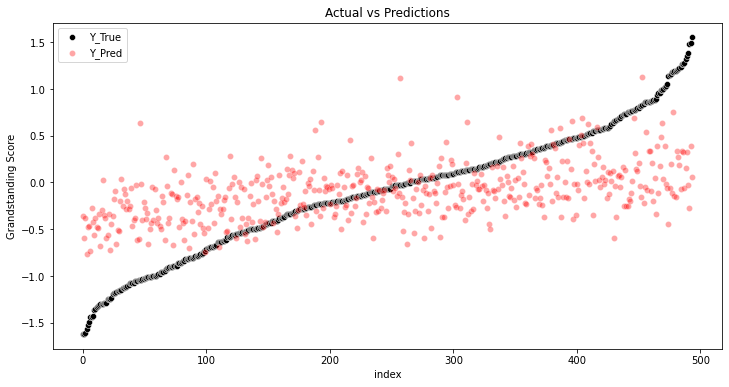

In [16]:
preds = grid.predict(X_test)
pred_df = pd.DataFrame(data={"y_true":y_test, "y_pred": preds})

pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
pred_df = pred_df.reset_index(drop = False)

figure, ax = plt.subplots(ncols = 1, figsize = (12,6))
g = sns.scatterplot(x = 'index', y = 'y_true', data = pred_df, alpha = 1, label = 'Y_True', color = 'k')
g = sns.scatterplot(x = 'index', y = 'y_pred', data = pred_df, alpha = .35, label = 'Y_Pred', color = 'red')
plt.title('Actual vs Predictions')
plt.ylabel('Grandstanding Score')
plt.show()

In [7]:
import lightgbm as lgb

In [8]:
params = {
    "num_leaves": 16,
    "max_depth": 8,
    "reg_lambda": .01,
    "objective": "regression"
}

train_data = lgb.Dataset(X_train, y_train, weight=y_weights)

lgb_bst = lgb.train(params, train_data, )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3559
[LightGBM] [Info] Number of data points in the train set: 1974, number of used features: 14
[LightGBM] [Info] Start training from score -0.183742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

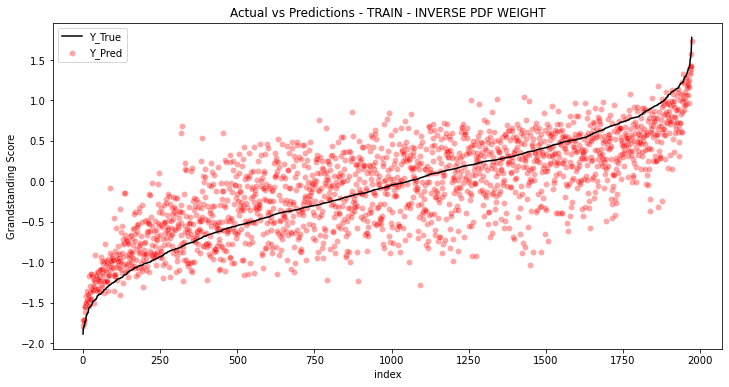

In [9]:
preds = lgb_bst.predict(X_train)
pred_df = pd.DataFrame(data={"y_true":y_train, "y_pred": preds})

pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
pred_df = pred_df.reset_index(drop = False)

figure, ax = plt.subplots(ncols = 1, figsize = (12,6))
g = sns.lineplot(x = 'index', y = 'y_true', data = pred_df, alpha = 1, label = 'Y_True', color = 'k')
g = sns.scatterplot(x = 'index', y = 'y_pred', data = pred_df, alpha = .35, label = 'Y_Pred', color = 'red')
plt.title('Actual vs Predictions - TRAIN - INVERSE PDF WEIGHT')
plt.ylabel('Grandstanding Score')
plt.show()

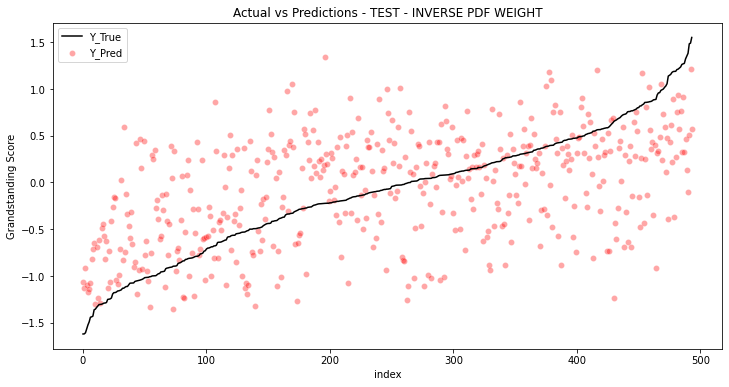

In [23]:
preds = lgb_bst.predict(X_test)
pred_df = pd.DataFrame(data={"y_true":y_test, "y_pred": preds})

pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
pred_df = pred_df.reset_index(drop = False)

figure, ax = plt.subplots(ncols = 1, figsize = (12,6))
g = sns.lineplot(x = 'index', y = 'y_true', data = pred_df, alpha = 1, label = 'Y_True', color = 'k')
g = sns.scatterplot(x = 'index', y = 'y_pred', data = pred_df, alpha = .35, label = 'Y_Pred', color = 'red')
plt.title('Actual vs Predictions - TEST - INVERSE PDF WEIGHT')
plt.ylabel('Grandstanding Score')
plt.show()

In [14]:
params = {
    "num_leaves": 16,
    "max_depth": 8,
    "reg_lambda": .01,
    "objective": "regression"
}

y_train[(y_train > 1) | (y_train < -1)]

train_sub_data = lgb.Dataset(X_train[(y_train > 1) | (y_train < -1)], y_train[(y_train > 1) | (y_train < -1)])
lgb_bst = lgb.train(params, train_sub_data, )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 307, number of used features: 14
[LightGBM] [Info] Start training from score -0.534967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

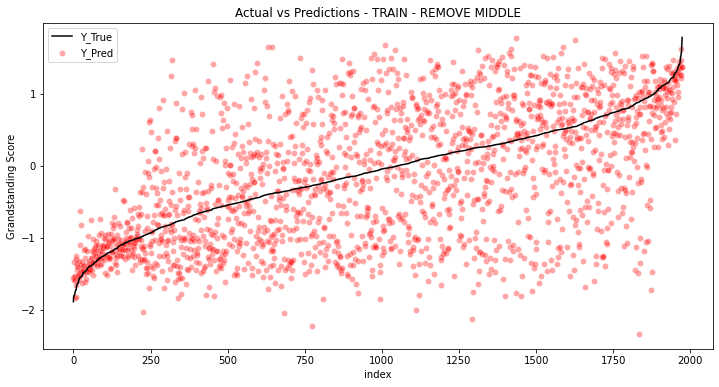

In [17]:
preds = lgb_bst.predict(X_train)
pred_df = pd.DataFrame(data={"y_true":y_train, "y_pred": preds})

pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
pred_df = pred_df.reset_index(drop = False)

figure, ax = plt.subplots(ncols = 1, figsize = (12,6))
g = sns.lineplot(x = 'index', y = 'y_true', data = pred_df, alpha = 1, label = 'Y_True', color = 'k')
g = sns.scatterplot(x = 'index', y = 'y_pred', data = pred_df, alpha = .35, label = 'Y_Pred', color = 'red')
plt.title('Actual vs Predictions - TRAIN - REMOVE MIDDLE')
plt.ylabel('Grandstanding Score')
plt.show()

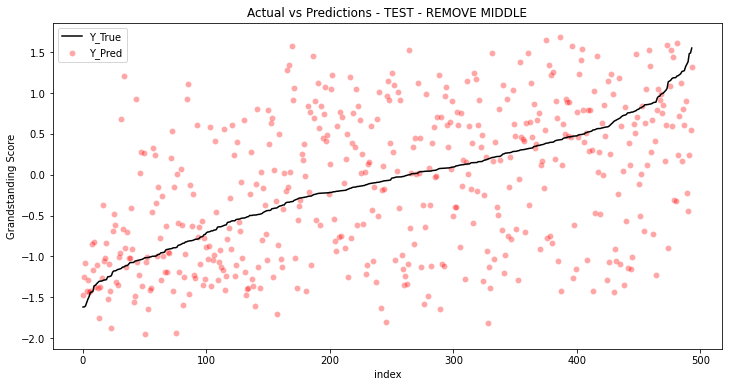

In [18]:
preds = lgb_bst.predict(X_test)
pred_df = pd.DataFrame(data={"y_true":y_test, "y_pred": preds})

pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
pred_df = pred_df.reset_index(drop = False)

figure, ax = plt.subplots(ncols = 1, figsize = (12,6))
g = sns.lineplot(x = 'index', y = 'y_true', data = pred_df, alpha = 1, label = 'Y_True', color = 'k')
g = sns.scatterplot(x = 'index', y = 'y_pred', data = pred_df, alpha = .35, label = 'Y_Pred', color = 'red')
plt.title('Actual vs Predictions - TEST - REMOVE MIDDLE')
plt.ylabel('Grandstanding Score')
plt.show()
